In [350]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier, LSHForest
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC

from sklearn.ensemble import BaggingClassifier
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import itertools
from nltk.util import skipgrams
from nltk.corpus import stopwords
from imblearn.over_sampling import     ADASYN, RandomOverSampler 
from sklearn.model_selection import GridSearchCV

In [26]:
def load_data():
    train = pd.read_csv('data/evo_train_clean.csv.gz', compression='gzip', index_col='id')
    categories = pd.read_csv('data/categories_parsed.csv.gz', compression='gzip', index_col='GROUP_ID')
    data = train.join(categories, on='GROUP_ID')
    return data

In [126]:
data = load_data()
data.head()

,NAME,GROUP_ID,category,sub_category
id,,,,
0,пиво жигулевский number литр св,35,Алкоголь,"Пиво, слабоалкогольные напитки"
1,соус томатный буздяк number год татарский number,6,Прод,Продукты питания
2,сигарета esse ss exchange,7,Непрод,Табачные изделия
3,петрушка,6,Прод,Продукты питания
4,пиво ягерь,35,Алкоголь,"Пиво, слабоалкогольные напитки"


In [266]:
mapper = {'Алкоголь': 'Прод', 'Прод': 'Прод', 'Непрод': 'Непрод', 'н/д': 'Непрод', 'Позиция по свободной цене': 'Непрод'}
data['supercategory'] = data['category'].apply(lambda row: mapper[row])
data.head()

,NAME,GROUP_ID,category,sub_category,supercategory
id,,,,,
0,пиво жигулевский number литр св,35,Алкоголь,"Пиво, слабоалкогольные напитки",Прод
1,соус томатный буздяк number год татарский number,6,Прод,Продукты питания,Прод
2,сигарета esse ss exchange,7,Непрод,Табачные изделия,Непрод
3,петрушка,6,Прод,Продукты питания,Прод
4,пиво ягерь,35,Алкоголь,"Пиво, слабоалкогольные напитки",Прод


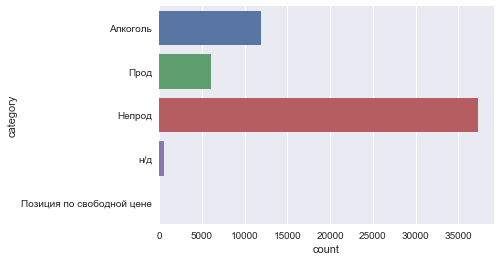

In [36]:
sns.countplot(y='category', data=data)

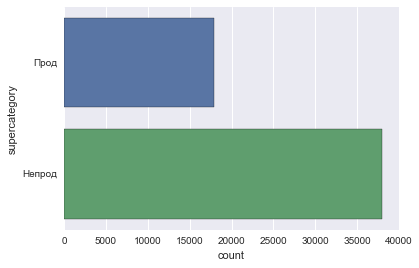

In [267]:
sns.countplot(y='supercategory', data=data)

In [309]:
def prepare_data_baseline(data):
    X = data['NAME']
    y = data['supercategory']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
from sklearn.metrics import accuracy_score, log_loss, classification_report

def show_metrics(y_true, y_pred, y_pred_proba):
    print("Accuracy: {}".format(accuracy_score(y_true, y_pred)))
    print("LogLoss: {}".format(log_loss(y_true, y_pred_proba)))
    print(classification_report(y_true, y_pred))
    cnf_matrix = confusion_matrix(y_true, y_pred)
#     sns.heatmap(cnf_matrix)
    plot_confusion_matrix(cnf_matrix, y_true.unique())

In [119]:
def tokenize(seq):
    tokens = seq.split()
    if len(tokens) > 1:
        return [" ".join(w) for w in skipgrams(tokens, 2, 3)]
    else:
        return tokens

In [347]:
def baseline(data, prepare_data, vectorizer):
    X_train, X_test, y_train, y_test = prepare_data(data)

    pipeline = Pipeline([
            ('count_vectorizer', vectorizer),
#             ('best', TruncatedSVD(n_components=100)),
#            ('clf', KNeighborsClassifier(n_neighbors=4))
            ('clf_category', LogisticRegression(C=1.5,solver='liblinear',class_weight='balanced', random_state=42))
#             ('clf', SGDClassifier(loss='log'))
        ])

    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(X_test)
    pred_proba = pipeline.predict_proba(X_test)
#     print("Vocabulary length: {}".format(len(vectorizer.vocabulary_)))
    show_metrics(y_test, pred, pred_proba)
    
    pred_df = pd.DataFrame(pred, index=X_test.index,columns=['predicted'])
    pred_df['real'] = y_test
    pred_df['NAME'] = X_test
    errors = pred_df[pred_df['real'] != pred_df['predicted']]
    
    return errors

In [232]:
stopwords_extra = []

Accuracy: 0.9041055018498627
LogLoss: 0.789796959387079
             precision    recall  f1-score   support

     Непрод       0.89      0.98      0.93     11401
       Прод       0.94      0.74      0.83      5357

avg / total       0.91      0.90      0.90     16758

Confusion matrix, without normalization
[[11165   236]
 [ 1371  3986]]
Errors count: 1607


,predicted,real,NAME
id,,,
39942,Прод,Непрод,фотоальбом толстый
36742,Непрод,Прод,коньяк армянский аршатар number number number ...
52510,Непрод,Прод,напиток спиртной финляндия блэккуррант number
48333,Непрод,Прод,набор подарочный для вино
15024,Непрод,Прод,зефира воздушный поцелуй клубничный


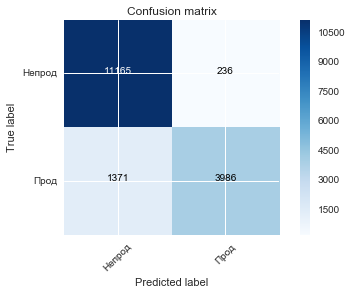

In [349]:
vectorizer = CountVectorizer( binary=False,ngram_range=(1,2) ,max_features=15000, stop_words=stopwords_extra + stopwords.words('russian') + stopwords.words('english'))
# vectorizer = HashingVectorizer(ngram_range=(1,2), stop_words=stopwords_extra + stopwords.words('russian') + stopwords.words('english'))
errors_baseline = baseline(data, prepare_data_baseline, vectorizer)
print("Errors count: {}".format(errors_baseline.shape[0]))
errors_baseline.head()

In [ ]:
def search_for_log_lin(data):
    param_grid = {'C': [1, 10, 100, 1000], 'kernel': ['linear']}
    

In [293]:
import operator
sorted(vectorizer.vocabulary_.items(), key=operator.itemgetter(1), reverse=True)

[('ёршик', 14999),
 ('ёрш', 14998),
 ('ёмкость свч', 14997),
 ('ёмкость', 14996),
 ('ёлочный', 14995),
 ('ёлочка', 14994),
 ('ёлка', 14993),
 ('ёжик number', 14992),
 ('ёжик', 14991),
 ('ящик рыболовный', 14990),
 ('ящик рассада', 14989),
 ('ящик инструмент', 14988),
 ('ящик игрушка', 14987),
 ('ящик далее', 14986),
 ('ящик балконный', 14985),
 ('ящик балк', 14984),
 ('ящик атол', 14983),
 ('ящик tandembox', 14982),
 ('ящик number', 14981),
 ('ящик', 14980),
 ('ящ', 14979),
 ('яшма', 14978),
 ('яшкино number', 14977),
 ('яшкино', 14976),
 ('ячменный фирменный', 14975),
 ('ячменный пол', 14974),
 ('ячменный колос', 14973),
 ('ячменный', 14972),
 ('ячейка', 14971),
 ('яч', 14970),
 ('ясень шить', 14969),
 ('ясень', 14968),
 ('ясельный', 14967),
 ('ярый', 14966),
 ('ярпиво янтарный', 14965),
 ('ярпиво крепкий', 14964),
 ('ярпиво', 14963),
 ('ярославль', 14962),
 ('ярмарка', 14961),
 ('ярко', 14960),
 ('яркий', 14959),
 ('японский', 14958),
 ('япония number', 14957),
 ('япония', 14956),
 (

In [241]:
#import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

def boosting(data, prepare_data, vectorizer):
    X_train, X_test, y_train, y_test = prepare_data(data)
    pipeline = Pipeline([
            ('count_vectorizer', vectorizer),
            #('clf_category', xgb.XGBClassifier(max_depth=15, seed=42, n_estimators=200))
            ('clf', RandomForestClassifier(random_state=42, n_estimators=50))
        ])

    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(X_test)
    pred_proba = pipeline.predict_proba(X_test)
    print("Vocabulary length: {}".format(len(vectorizer.vocabulary_)))
    show_metrics(y_test, pred, pred_proba)
    
    pred_df = pd.DataFrame(pred, index=X_test.index,columns=['predicted'])
    pred_df['real'] = y_test
    pred_df['NAME'] = X_test
    errors = pred_df[pred_df['real'] != pred_df['predicted']]
    
    return errors

Vocabulary length: 15000
Accuracy: 0.9517842224609142
LogLoss: 0.16882632971102976
             precision    recall  f1-score   support

     Непрод       0.96      0.97      0.96     11401
       Прод       0.94      0.90      0.92      5357

avg / total       0.95      0.95      0.95     16758

Confusion matrix, without normalization
[[11105   296]
 [  512  4845]]
Errors count: 808


,predicted,real,NAME
id,,,
26914,Прод,Непрод,аром соль для ванна океанический number год
20510,Прод,Непрод,тонер для лицо с экстракт соевый боб estheroce...
43089,Непрод,Прод,мален акконда
49520,Прод,Непрод,кофе hausbrandt nero espresso
54820,Непрод,Прод,number °по фаренгейт р брэдбрать


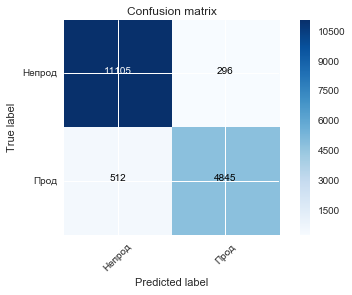

In [294]:
# vectorizer = CountVectorizer( binary=True, max_features=10000, stop_words=stopwords_extra + stopwords.words('russian') + stopwords.words('english'))
vectorizer = CountVectorizer( binary=True,ngram_range=(1,2) ,max_features=15000, stop_words=stopwords_extra + stopwords.words('russian') + stopwords.words('english'))
errors = boosting(data, prepare_data_baseline, vectorizer)
print("Errors count: {}".format(errors.shape[0]))
errors.head()

In [246]:
def ensemble(data, prepare_data, vectorizer):
    X_train, X_test, y_train, y_test = prepare_data(data)
    
    pipeline = Pipeline([
            ('count_vectorizer', vectorizer),
            ('clf', VotingClassifier(
                [
                    ('knn', BaggingClassifier(LogisticRegression(class_weight='balanced'))),
                    ('nb', BaggingClassifier(MultinomialNB())), 
                    ('rf',RandomForestClassifier(random_state=42, n_estimators=50))], 
                voting='soft'
            ))
        ])

    pipeline.fit(X_train, y_train)
    pred = pipeline.predict(X_test)
    pred_proba = pipeline.predict_proba(X_test)
    print("Vocabulary length: {}".format(len(vectorizer.vocabulary_)))
    show_metrics(y_test, pred, pred_proba)
    
    pred_df = pd.DataFrame(pred, index=X_test.index,columns=['predicted'])
    pred_df['real'] = y_test
    pred_df['NAME'] = X_test
    errors = pred_df[pred_df['real'] != pred_df['predicted']]
    
    return errors

Vocabulary length: 15000
Accuracy: 0.967358873373911
LogLoss: 0.09579215145565259
             precision    recall  f1-score   support

     Непрод       0.96      0.99      0.98     11401
       Прод       0.98      0.92      0.95      5357

avg / total       0.97      0.97      0.97     16758

Confusion matrix, without normalization
[[11276   125]
 [  422  4935]]
Errors count: 547


,predicted,real,NAME
id,,,
26914,Прод,Непрод,аром соль для ванна океанический number год
43089,Непрод,Прод,мален акконда
49520,Прод,Непрод,кофе hausbrandt nero espresso
54820,Непрод,Прод,number °по фаренгейт р брэдбрать
34708,Непрод,Прод,рыжий соня стекло number number


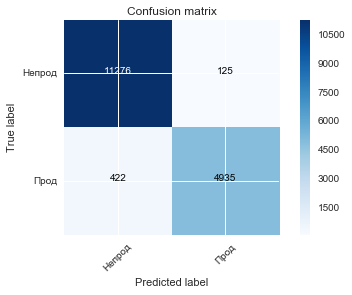

In [296]:
vectorizer = CountVectorizer( binary=True,ngram_range=(1,2) ,max_features=15000, stop_words=stopwords_extra + stopwords.words('russian') + stopwords.words('english'))
errors = ensemble(data, prepare_data_baseline, vectorizer)
print("Errors count: {}".format(errors.shape[0]))
errors.head()